In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='ae1a755d-e162-4f07-9f5a-130d2280e78e', project_access_token='p-aa90b9b21de435c3f4c94494a24b5c5e69d030f8')
pc = project.project_context


# Extracting entities in hotel reviews using Watson NLP

This notebook demonstrates how to perform entity extration and keyword phrase extraction using Watson NLP. The models extract useful mentions from the text of customer reviews. This could be used, for example to route a complaint to the appropriate staff member or to detect common issues within a facility.

The data that is used in this notebook is the data scraped from Booking.com. This dataset contains 515,000 customer reviews and scoring of 1493 luxury hotels across Europe. A reviews contains the customer’s narrative description of their experience. In this notebook, you will focus on classifying the reviews as complaints that contain this narrative description to show how to use Watson NLP.

The data is sourced from the publicly available [Kaggle 515K Hotel Reviews Data in Europe](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe) and [OpinRank Review Dataset](https://archive.ics.uci.edu/ml/datasets/OpinRank+Review+Dataset). The dataset used in this notebook has combined and transformed both datasets for a cleaner and simpler approach to the data preparation step.


## What you'll learn in this notebook

Watson NLP implements state-of-the-art classification algorithms from three different families: 
- Classic machine learning using SVM (Support Vector Machines)
- Deep learning using CNN (Convolutional Neural Networks)
- A transformer-based algorithm using the Google BERT multilingual model 

Watson NLP also offers an easy to use _ensemble classifier_ which combines different classification algorithms and a majority voting.

In this notebook, you'll learn how to:

- **Explore a Rule Based model** using `watson_nlp.blocks.entity_mentions.RBR`. RBR stands for Rule Based. The RBR block does not depend on any blocks so the raw document text can be directly input to the model. The RBR handles syntactically regular entity types such as number, email and phone.
- **Explore a BiLSTM** using `watson_nlp.blocks.entity_mentions.BiLSTM`. BiLSTM stands for Bidirectional LSTM. The BiLSTM model uses GloVe embeddings trained on the Wikipedia corpus in each language.
- **Explore a BERT** using `watson_nlp.blocks.entity_mentions.BERT`. BERT stands for Bidirectional Encoder Representations from Transformers. BERT model uses the Google Multilingual BERT model, meaning that a single model can analyze input texts from multiple languages.
- **Explore a Keyword Text Rank** using `watson_nlp.blocks.keywords.TextRank`. The keywords block ranks noun phrases extracted from an input document based on how relevant they are within the document. 
- **Analyze Sentiment in Entity Mentions** using `watson_nlp.blocks.sentiment.SentenceSentimentBERT`. 


## Table of Contents


1.	[Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.  [Entity Extraction](#entity)
    1. [Entity extraction functions](#functions)
    1. [Run entity extraction](#run)
    1. [Hotel Comparison](#hotel)
    1. [Website Comparison](#website)
1.  [Keyword Extraction](#keyword)
1.  [Target Sentiment Analysis](#targetSentiment)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
## 1. Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _DO + NLP Runtime 22.1 on Python 3.9_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>

In [2]:
%%capture
# word cloud is used to create graphs below
!pip install wordcloud
!pip install ibm-watson

In [3]:
# Silence Tensorflow warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

In [4]:
import json
import pandas as pd
from time import process_time
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import watson_nlp

<a id="loadData"></a>
## 2. Data Loading (hotel review/customer complaint data)

The data for each of the hotels can be downloaded from Github: [Hotel 1](https://github.com/ibm-build-labs/Watson-NLP/blob/main/Entities-Keywords-Extraction/uk_england_london_belgrave_hotel.csv), [Hotel 2](https://github.com/ibm-build-labs/Watson-NLP/blob/main/Entities-Keywords-Extraction/uk_england_london_dorset_square.csv), [Hotel 3](https://github.com/ibm-build-labs/Watson-NLP/blob/main/Entities-Keywords-Extraction/uk_england_london_euston_square_hotel.csv).

Since these CSVs should already be in the reserved environment, we will use the Project library to load all three files as DataFrames.

<span style="color:blue">The DataFrames have columns `date`, `text`, `website`, and `hotel`. <br>`Date` column is the published date of the review. <br>`Text` column is the customer review. <br>`Website` column is the travel website platform for reviews. <br>`Hotel` column is the name of the hotel. <br>Reviews include both negative and positive reviews.</span>

In [5]:
belgrave = project.get_file('uk_england_london_belgrave_hotel.csv')
belgrave_df = pd.read_csv(belgrave)

In [6]:
euston = project.get_file('uk_england_london_euston_square_hotel.csv')
euston_df = pd.read_csv(euston)

In [7]:
dorset = project.get_file('uk_england_london_dorset_square.csv')
dorset_df = pd.read_csv(dorset)

We can examine one of the hotels to see their values.

In [8]:
# preview the one of the DataFrames
dorset_df.head()

,date,text,website,hotel
0,2017-07-13,Although I appreciate this is a 4 star and not a 5 star it is nowhere near the standard of the other Firmdale hotels we have stayed at Room we had looked over a busy road not the leafy garden square and had just a shower no bath Very friendly staff good cocktails in bar,Booking.com,Dorset
1,2017-06-26,A night time bottle of water on the second night or something similar Beautiful furnishings comfortable bed gorgeous view of Dorset Square very pleasant staff,Booking.com,Dorset
2,2017-06-12,Our room was very small and had no view Tea and coffee facilities in the room would be an added bonus The hotel is beautifully decorated The staff was very friendly and accommodating The restaurant had a good breakfast selection I can definitely recommend the hotel to anybody who would like a boutique hotel experience The hotel is within walking distance from Lords cricket grounds The mini ...,Booking.com,Dorset
3,2017-06-06,The bed was a bit small and short given that we are rather tall people Even though we thoroughly enjoyed breakfast the selection could have benefitted from also some more savoury items next to the egg varieties such as some cheese cold cuts Nothing really to find fault with Overall a very well maintained property Beautiful room although a bit small with a nice view of the square Equally bea...,Booking.com,Dorset
4,2017-05-29,We didnt like our first room but the staff traded our room when we asked They were as helpful as they could be while being totally booked up We loved the location as well as the staff Lorenzo and Sarah from the front desk were incredibly helpful as well as Virgil and all the others we had a wonderful time,Booking.com,Dorset


<a id="entity"></a>
## 3. Entity extraction

Entity extraction uses the `entity-mentions` block to encapsulate algorithms for the task of extracting mentions of entities (person, organizations, dates, locations,...) from the input text. The block offers implementations of strong entity extraction algorithms from each of the four families: rule-based, classic ML, deep-learning and transformers.

There are two types of models:

1. A rule-based model (the rbr models), which handles syntactically regular entity types such as number, email and phone.
1. A model trained on labeled data for the more complex entity types such as person, organization location.

<a id="function"></a>
### 3a. Entity extraction function

Rule-based models (rbr) do not depend on any blocks, so you can just directly run them on input text.

Models trained from labeled data, such as `bilstm`, `bert`, and `transformer`, depend on the Syntax block. As such, Syntax block must be run first to generate the input expected by the Entity Mention block.

<span style="color:blue">We will load the syntax model and three entity extraction models</span>

In [9]:
# Load a syntax model to split the text into sentences and tokens
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))
# Load bilstm model in WatsonNLP
bilstm_model = watson_nlp.load(watson_nlp.download('entity-mentions_bilstm_en_stock'))
# Load rbr model in WatsonNLP
rbr_model = watson_nlp.load(watson_nlp.download('entity-mentions_rbr_en_stock'))
# Load bert model in WatsonNLP
bert_model = watson_nlp.load(watson_nlp.download('entity-mentions_bert_multi_stock'))
# Load transformer model in WatsonNLP
#transformer_model = watson_nlp.load(watson_nlp.download('entity-mentions_transformer_multi_stock'))

<span style="color:blue">The following function is built to run a specified entity extraction model and parse its results. The returned output is a dictionary of the review text, hotel name, website, and entity mentions.</span>

In [10]:
def extract_entities(data, model, hotel_name=None, website=None):
    import html
    
    input_text = str(data)
    text = html.unescape(input_text)
    if model == 'rbr':
        # Run rbr model on text
        mentions = rbr_model.run(text)
    else:
        # Run syntax model on text 
        syntax_result = syntax_model.run(text)
        if model == 'bilstm':
            # Run bilstm model on syntax result
            mentions = bilstm_model.run(syntax_result)
        elif model == 'bert':
            # Run bert model on syntax result
            mentions = bert_model.run(syntax_result)
        elif model == 'transformer':
            # Run transformer model on syntax result
            mentions = transformer_model.run(syntax_result)
            
    entities_list = mentions.to_dict()['mentions']
    ent_list=[]
    for i in range(len(entities_list)):
        ent_type = entities_list[i]['type']
        ent_text = entities_list[i]['span']['text'] 
        ent_list.append({'ent_type':ent_type,'ent_text':ent_text})
        
    if len(ent_list) > 0:
        return {'Document':input_text,'Hotel Name':hotel_name,'Website':website,'Entities':ent_list}
    else:
        return {}

Stop-words are common words that are unmeaningful for separating the data. Such common words are assumed to be "noise" as their high frequency could hide the words carrying more informative signal. We filter   them based on a pre-defined list used in WatsonNLP and based on the part-of-speech. Notes:

1. The stop-words list can be customized for the target dataset. We demonstrate this below.
1. When we vectorize the documents below, we apply a filter that ignores terms that appear in 50% or more of the documents. This filter can also be counted as part of stop-words filtering.

In [11]:
wnlp_stop_words = watson_nlp.download_and_load('text_stopwords_classification_ensemble_en_stock').stopwords
stop_words = list(wnlp_stop_words)
stop_words.remove('keep')
stop_words.extend(["gimme", "lemme", "cause", "'cuz", "imma", "gonna", "wanna", 
                   "gotta", "hafta", "woulda", "coulda", "shoulda", "howdy","day", 
                   "first", "second", "third", "fourth", "fifth", "London", "london", 
                   "1st", "2nd", "3rd", "4th", "5th", 
                   "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", 
                   "weekend", "week", "evening", "morning"])

In [12]:
# Pre-processing steps 
import string
exclude = set(string.punctuation)
def clean(doc):
    import html
    # replacing &amp to & as it is HTML tag
    stop_free = " ".join([html.unescape(word) for word in doc.split() if word.lower() not in stop_words])
    return stop_free

<a id="run"></a>
### 3b. Run entity extraction

<span style="color:blue">Creating a list of our hotel DataFrames will allow for automation of the extraction process. The following function runs the the `clean()` function on input text/documents and then runs the cleaned text through the model. The model used can be specified via the `model` parameter in `extract_entities()`.</span>

In [13]:
euston_df

,date,text,website,hotel
0,2017-08-02,Rooms very small street noise shower was very small and there was a blue led light in the bathroom so I couldn t see properly No answer when ringing front desk and no answer when ringing room service Comfortable bed staff friendly good food at restaurant good location property seemed clean nice flatscreen TV,Booking.com,Euston
1,2017-07-11,Chiming from a local clock every 15mins but even this seemed to cease during the early hours Staff were lovely breakfast had a good selection room was spacious and the bed was very comfortable Easy access to all amenities perfect for our requirements,Booking.com,Euston
2,2017-07-11,The receipetionest on the night that I check in the service of the staff is not friendly and not welcoming Secondly the receipetionest double check in me which mean he checked in me with a room that have another guest Moreover when I checked in my room is on the 5th floor but due to the renovation so I have to take the stairs the problem here is that I m having a lot of luggages with me it is...,Booking.com,Euston
3,2017-07-05,It was very noisy at the property Workmen were doing drilling and renovations right outside the breakfast room The sound made us leave rather than enjoy the breakfast offerings because it was so loud The hotel really should have asked the workmen to begin work in that particular area after breakfast service I understand that renovations need to be undertaken but more care should be taken in r...,Booking.com,Euston
4,2017-07-01,Reception staff seem to have problems booking people in ie couldn t find our name and told us we weren t booked in before checking system properly Not just us Also front rooms seem to have too much traffic noise Location cleanliness,Booking.com,Euston
...,...,...,...,...
1767,2004-11-08,"Many London hotels are not great, but this is the worst I have ever ever stayed at. Dirty rooms, had to upgrade to an executive room just to get a working telephone. It must have got its 3 stars 20 years ago. Do not visit.",TripAdvisor,Euston
1768,2004-11-03,"I stayed in this hotel for 3 nights in October and if I hadn't paid in advance would not have stayed 3 minutes. I have stayed in many hotels in many places over the years but can honestly say this was the worst. The room was small, not very clean (bedcover and blanket stained and carpet dirty) although the sheet and ONE pillow was clean and changed daily. THe shower was OK and batroom reasonab...",TripAdvisor,Euston
1769,2004-09-30,"This place does not give you all you would expect from a london hotel. The nicest place to be is the foyer, the rooms are small and grotty, the staff are miserable (management) and the electricity and telephones are not reliable, in all a terrible stay.",TripAdvisor,Euston
1770,2004-09-18,The room was filthy with what appeared to be feces on the spread. Construction noise from 8 to 5. Very very small. My wife felt we lucky we didn't leave with lice. We are extensive travelers and this was by far the worst room we have ever stayed in.,TripAdvisor,Euston


In [14]:
hotels_df_list = [belgrave_df, euston_df, dorset_df]

In [15]:
def run_extraction(df_list, text_col):
    extract_list = []
    for df in df_list:
        all_text = dict(zip(df[text_col], zip(df['hotel'], df['website'])))
        all_text_clean = {clean(doc[0]): doc[1] for doc in all_text.items()}
        for text in all_text_clean.items():
            # change the second parameter to 'rbr', 'bilstm', or 'bert' to try other models
            extract_value = extract_entities(text[0], 'bilstm', text[1][0], text[1][1])
            if len(extract_value) > 0:
                extract_list.append(extract_value)              
    return extract_list

In [16]:
extract_list = run_extraction(hotels_df_list, 'text')

<span style="color:blue">The model will output a text's entity mention as well as its category of entity. For example, "london" mention is a `Location` type and "good soundproof rooms" is a `Facility` type.</span>

In [17]:
analysis_df=pd.DataFrame(columns=['Document','Hotel Name', 'Website', 'Entities'])
analysis_df=analysis_df.append(extract_list,ignore_index = True)
exp_entities = analysis_df.explode('Entities')
entities_df = pd.concat([exp_entities.drop('Entities', axis=1), exp_entities['Entities'].apply(pd.Series)], axis=1)
entities_df.tail()

,Document,Hotel Name,Website,ent_type,ent_text
1507,"Dorset Square Hotel conveniently located, moderately priced luxury hotel. blocks Wax museum London. street pleasant, peaceful park named (what else) Dorset Square, adds quiet ambiance. proximity busy streets tourist attractions.We nights April, 2000 enjoyed stay. restaurant served excellent breakfast, offered English European fare. Buses taxi's easy catch, great night spots short distance away...",Dorset,TripAdvisor,Location,street pleasant
1507,"Dorset Square Hotel conveniently located, moderately priced luxury hotel. blocks Wax museum London. street pleasant, peaceful park named (what else) Dorset Square, adds quiet ambiance. proximity busy streets tourist attractions.We nights April, 2000 enjoyed stay. restaurant served excellent breakfast, offered English European fare. Buses taxi's easy catch, great night spots short distance away...",Dorset,TripAdvisor,Facility,Dorset Square
1507,"Dorset Square Hotel conveniently located, moderately priced luxury hotel. blocks Wax museum London. street pleasant, peaceful park named (what else) Dorset Square, adds quiet ambiance. proximity busy streets tourist attractions.We nights April, 2000 enjoyed stay. restaurant served excellent breakfast, offered English European fare. Buses taxi's easy catch, great night spots short distance away...",Dorset,TripAdvisor,Date,"April, 2000"
1507,"Dorset Square Hotel conveniently located, moderately priced luxury hotel. blocks Wax museum London. street pleasant, peaceful park named (what else) Dorset Square, adds quiet ambiance. proximity busy streets tourist attractions.We nights April, 2000 enjoyed stay. restaurant served excellent breakfast, offered English European fare. Buses taxi's easy catch, great night spots short distance away...",Dorset,TripAdvisor,Organization,English European
1507,"Dorset Square Hotel conveniently located, moderately priced luxury hotel. blocks Wax museum London. street pleasant, peaceful park named (what else) Dorset Square, adds quiet ambiance. proximity busy streets tourist attractions.We nights April, 2000 enjoyed stay. restaurant served excellent breakfast, offered English European fare. Buses taxi's easy catch, great night spots short distance away...",Dorset,TripAdvisor,Facility,away.This hotel


<a id="hotel"></a>
### 3c. Comparing top 20 entities for each hotel

We can examine the results of the entity extraction by plotting the top frequently mentioned entities for each hotel. These mentions can be used to generate tags for a hotel to create relevancy and familiarity for search engine results.

<span style="color:blue">Let's display frequency with horizontal barcharts.</span>

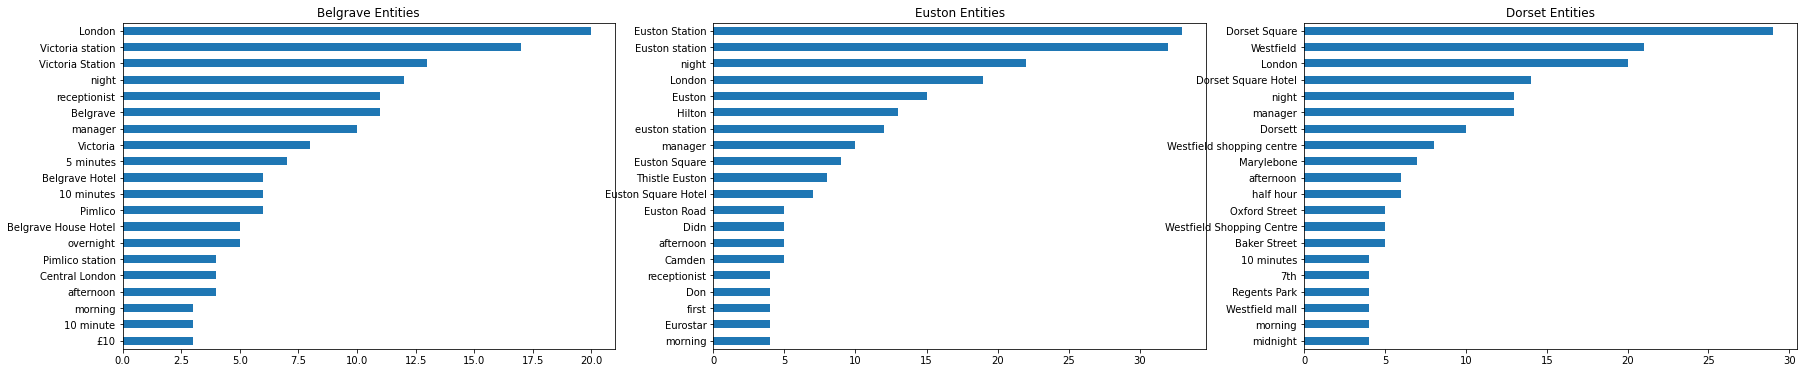

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))
entities_df[entities_df['Hotel Name'] == 'Belgrave']['ent_text'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[0], title='Belgrave Entities')
entities_df[entities_df['Hotel Name'] == 'Euston']['ent_text'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[1], title='Euston Entities') 
entities_df[entities_df['Hotel Name'] == 'Dorset']['ent_text'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[2], title='Dorset Entities') 

plt.show()

<span style="color:blue">We can also plot the the frequency of the various entity types for each hotel. We can see that the most importantly reviewed attributes of a hotel are related to the facility, location, and organization. These are areas that management can look to target in more detail to understand what can be improved.</span>

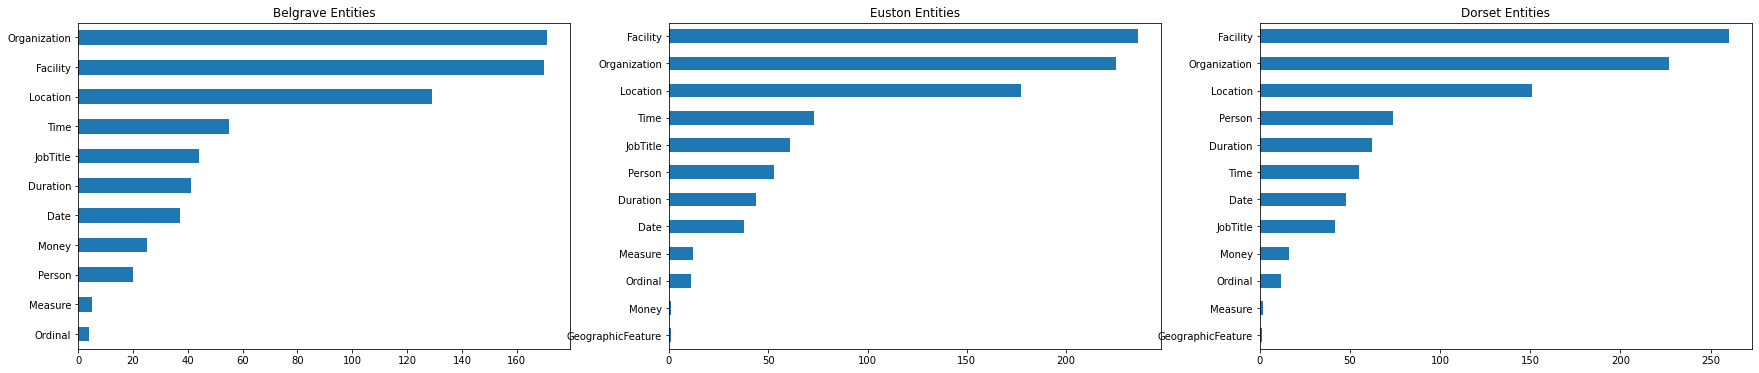

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))
entities_df[entities_df['Hotel Name'] == 'Belgrave']['ent_type'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[0], title='Belgrave Entities')
entities_df[entities_df['Hotel Name'] == 'Euston']['ent_type'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[1], title='Euston Entities') 
entities_df[entities_df['Hotel Name'] == 'Dorset']['ent_type'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[2], title='Dorset Entities') 

plt.show()

<span style="color:blue">Additionally the following code can be used to examine the review texts for a particular entity type at a specific hotel.</span>

In [20]:
# Entities for Belgrave Hotel where the entity type is Facility
entities_df[(entities_df['Hotel Name'] == 'Belgrave') & (entities_df['ent_type'] == 'Facility')]['ent_text']

1             Victorias station Pimlico line Good soundproof rooms
7      walk tube station Decent 20mins walk Buckingham palace Nice
11                                      Pimlico station tv English
16                                           Pimlico station hotel
16                                           Pimlico Victoria Tube
                                  ...                             
360                                             London.Worst hotel
360                          there.Though mentionned website hotel
362                               station bus station tube station
368                                           Belgrave House Hotel
370               Hotel iswithin walking distance victoria station
Name: ent_text, Length: 170, dtype: object

In [21]:
def create_word_cloud(top_level_cat_df, text):
    figure, ax1 = plt.subplots(ncols=1, figsize=(10,6))
    wc = WordCloud(width=600, height=400, background_color ='white').generate_from_frequencies(top_level_cat_df.value_counts().head(20))
    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis('off')
    ax1.title.set_text(text)
    plt.show()
    
def create_word_cloud_list(df_list, text, name_list):
    figure, ax1 = plt.subplots(ncols=len(df_list), figsize=(10*len(df_list),6))
    for i in range(0, len(df_list)):
        wc = WordCloud(width=600, height=400, background_color ='white').generate_from_frequencies(df_list[i].value_counts().head(20))
        ax1[i].imshow(wc, interpolation="bilinear")
        ax1[i].axis('off')
        ax1[i].title.set_text(name_list[i] + ' ' + text)
    plt.show()

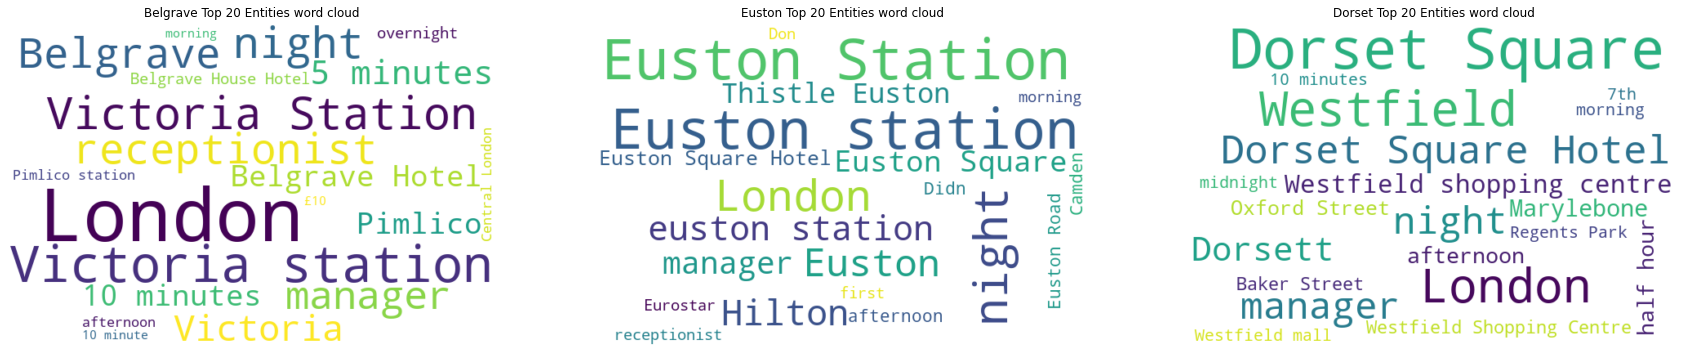

In [22]:
df_list = [entities_df[entities_df['Hotel Name'] == 'Belgrave']['ent_text'], 
           entities_df[entities_df['Hotel Name'] == 'Euston']['ent_text'], 
           entities_df[entities_df['Hotel Name'] == 'Dorset']['ent_text']]
name_list = ['Belgrave', 'Euston', 'Dorset']
create_word_cloud_list(df_list, "Top 20 Entities word cloud", name_list)

<span style="color:blue">To better display the list of entities that we can use as tags for each hotel, we can plot word clouds.</span>

<a id="website"></a>
### 3d. Comparison between Booking.com vs TripAdvisor for one hotel

Another approach to analyzing hotel customer reviews is by comparing the entity mentions found on the two websites where the reviews are published. Here we are looking at Booking.com vs TripAdvisor. We can hope to gain insight on the tendencies of reviewers who use one platform compared to the other platform.

<span style="color:blue">Let's plot side-by-side word clouds for each of the hotels.</span>

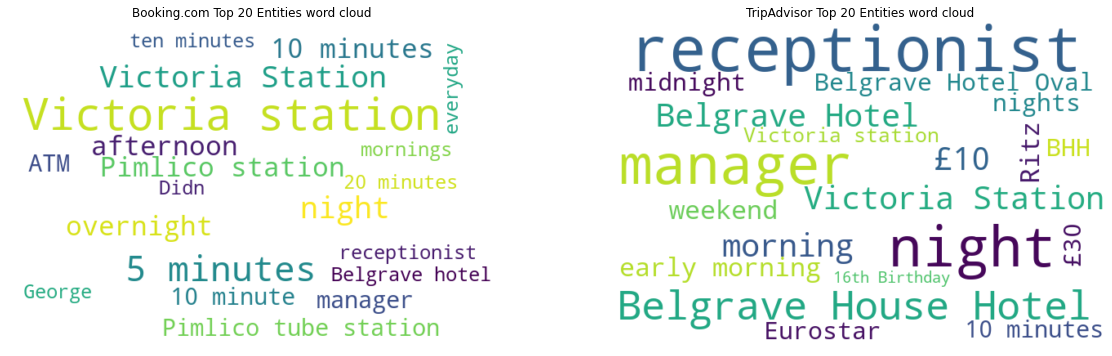

In [23]:
df_list = [entities_df[(entities_df['Hotel Name'] == 'Belgrave') & (entities_df['Website'] == 'Booking.com') & (entities_df['ent_type'] != 'Location')]['ent_text'], 
           entities_df[(entities_df['Hotel Name'] == 'Belgrave') & (entities_df['Website'] == 'TripAdvisor') & (entities_df['ent_type'] != 'Location')]['ent_text']]
name_list = ['Booking.com', 'TripAdvisor']
create_word_cloud_list(df_list, "Top 20 Entities word cloud", name_list)

Looks like customers on Booking.com care more about the convenience to tube stations where as TripAdvisor customers care more about the reception and atmosphere of the hotel itself.

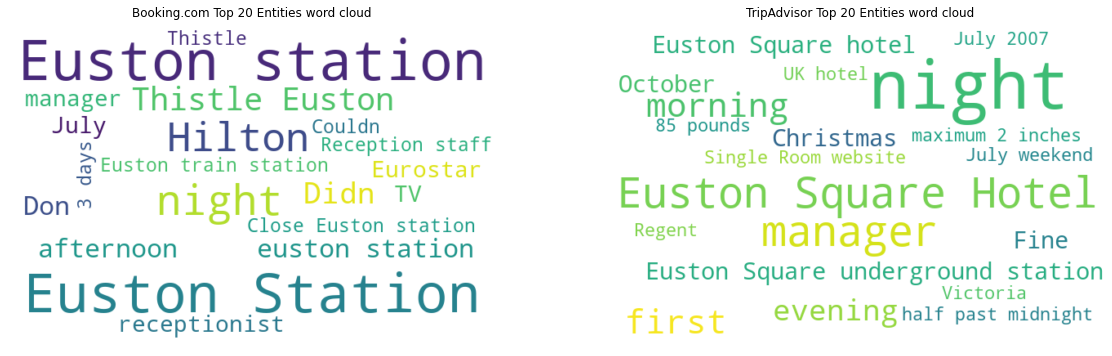

In [24]:
df_list = [entities_df[(entities_df['Hotel Name'] == 'Euston') & (entities_df['Website'] == 'Booking.com') & (entities_df['ent_type'] != 'Location')]['ent_text'], 
           entities_df[(entities_df['Hotel Name'] == 'Euston') & (entities_df['Website'] == 'TripAdvisor') & (entities_df['ent_type'] != 'Location')]['ent_text']]
name_list = ['Booking.com', 'TripAdvisor']
create_word_cloud_list(df_list, "Top 20 Entities word cloud", name_list)

Once again, we can see that customers on Booking.com care more about the convenience to tube stations where as TripAdvisor customers care more about the reception and atmosphere of the hotel itself.

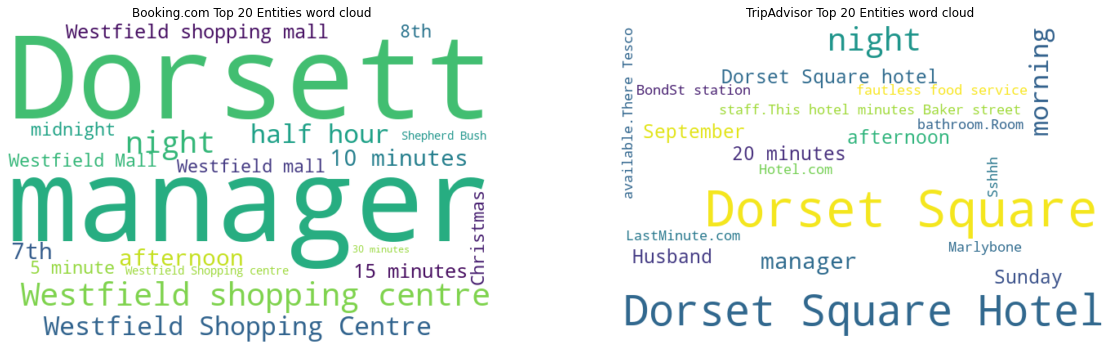

In [25]:
df_list = [entities_df[(entities_df['Hotel Name'] == 'Dorset') & (entities_df['Website'] == 'Booking.com') & (entities_df['ent_type'] != 'Location')]['ent_text'], 
           entities_df[(entities_df['Hotel Name'] == 'Dorset') & (entities_df['Website'] == 'TripAdvisor') & (entities_df['ent_type'] != 'Location')]['ent_text']]
name_list = ['Booking.com', 'TripAdvisor']
create_word_cloud_list(df_list, "Top 20 Entities word cloud", name_list)

We can use this collective information to give priority to the website with reviews that better align with our own preferences about choosing a hotel. Do we care more about the convenience of the location of a hotel or do we care about the hotel's ambience, reception, perks?

<a id="keyword"></a>
## 4. Keyword phrase extraction

Another Watson NLP capability we can utilize to analyze the hotel reviews is Keyword phrase extraction. The `keywords` block ranks noun phrases extracted from an input document based on how relevant they are within the document.

We will be using the `text-rank` model here. The text-rank model takes the output of Noun Phrase models and assigns a relevance score for each extracted noun phrase. The relevance score calculation is inspired by the Page Rank algorithm. In the context of the input document, extracted noun phrases that appear in “more connected” contexts receive a higher rank. In addition, the relevance score of extracted noun phrases is upgraded when the noun phrase appears more frequently in Wikipedia.

In [26]:
# Keyword Extraction
# Load Noun Phrases, Embedding and Keywords models for English
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))
noun_phrases_model = watson_nlp.load(watson_nlp.download('noun-phrases_rbr_en_stock'))
keywords_model = watson_nlp.load(watson_nlp.download('keywords_text-rank_en_stock'))

In [27]:
pos_filter = {
    4,      # POS_AUX
    10,     # POS_PART
    11,     # POS_PRON
    15,     # POS_SYM
    17      # POS_X
}

def custom_tokenizer(text):
    # parse the text for pos tagging and lemmatization
    result = syntax_model.run(text, parsers=('part_of_speech', 'lemma'))

    # collect the terms that qualify as meaningful.
    # to qualify, a term must meet all conditions:
    # (a) not be pos-tagged as symbol / content-less word
    # (b) not be a stop-word from the pre-defined list
    # (c) be longer than 1 character
    terms = []
    for token in result.tokens:
        pos_tag = token.part_of_speech
        if pos_tag not in pos_filter:
            lemma = token.lemma.strip()
            text = token.span.text.strip()
            term = lemma if len(lemma) > 0 else text
            if len(term) >1:
                terms.append(term)
    return " ".join(terms)

This Keyword model depends on the Syntax and Noun Phrases blocks. 

<span style="color:blue">The following function captures the flow for running a keyword extraction model. First, we run the input document/text through the syntax model and the noun phrases model to extract noun texts. Then, we use both syntax output and noun output as inputs for the keyword model where the ouput will include the text phrase and relevance score. We can use this score to rank the phrases.</span>

In [28]:
def extract_keywords(text):
    # Run the Syntax and Noun Phrases models
    syntax_prediction = syntax_model.run(text, parsers=('token', 'lemma', 'part_of_speech'))
    noun_phrases = noun_phrases_model.run(text)
    # Run the keywords model
    keywords = keywords_model.run(syntax_prediction, noun_phrases, limit=5)  
    keywords_list = keywords.to_dict()['keywords']
    key_list = []
    for i in range(len(keywords_list)):
        dict_list = {}
        key = custom_tokenizer(keywords_list[i]['text'])
        dict_list['phrase'] = key
        dict_list['relevance'] = keywords_list[i]['relevance']
        key_list.append(dict_list)
    return {'Complaint data':text,'Phrases':key_list}

In [29]:
def top_doc_generator(hotel_name):
    top_doc_list =[]
    for index, row in analysis_df.iterrows():
        if row['Hotel Name'] == hotel_name:
            top_doc_list.append(row['Document'])
    return top_doc_list

In [30]:
top_doc_euston = top_doc_generator('Euston')
top_doc_dorset = top_doc_generator('Dorset')
top_doc_belgrave = top_doc_generator('Belgrave')

In [31]:
def explode_phrases(top_doc_list):
    keywords = [extract_keywords(doc) for doc in top_doc_list] 
    phrases_df = pd.DataFrame(keywords)

    exp_phrases = phrases_df.explode('Phrases')
    exp_phrases = exp_phrases.dropna(subset=['Phrases'])
    exp_phrases = pd.concat([exp_phrases.drop(['Phrases'], axis=1), exp_phrases['Phrases'].apply(pd.Series)], axis=1)
    exp_phrases['phrase_length'] = exp_phrases['phrase'].apply(lambda x: len(x.split(' ')))
    # Removing uni-gram and bi-grams
    exp_phrases = exp_phrases[exp_phrases.phrase_length > 2]
    return exp_phrases

In [32]:
exp_phrases_euston = explode_phrases(top_doc_euston)
exp_phrases_dorset = explode_phrases(top_doc_dorset)
exp_phrases_belgrave = explode_phrases(top_doc_belgrave)

<span style="color:blue">We can further understand the results of the keyword phrase extraction model by plotting the top 20 more relevant phrases for each hotel. Notice that the relevance score of the top 20 phrases is above 0.98, meaning that there are plenty more phrases with high relevance that aren't being shown here. </span>

(0.985, 1.0)

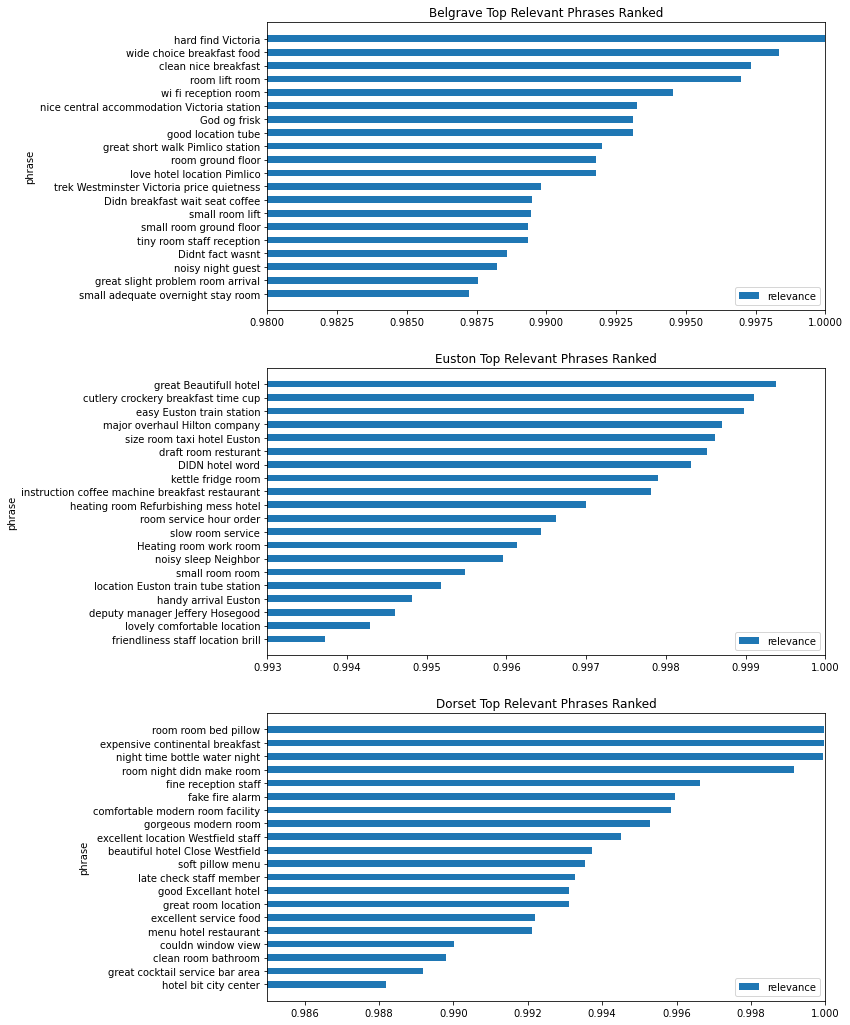

In [33]:
fig, ax2 = plt.subplots(nrows=3, figsize=(10,18))
exp_phrases_belgrave.sort_values('relevance', ascending=True).tail(20).plot.barh(x='phrase',y='relevance', title='Belgrave Top Relevant Phrases Ranked', ax=ax2[0])
ax2[0].autoscale()
ax2[0].set_xlim(0.98,1.0)
exp_phrases_euston.sort_values('relevance', ascending=True).tail(20).plot.barh(x='phrase',y='relevance', title='Euston Top Relevant Phrases Ranked', ax=ax2[1])
ax2[1].autoscale()
ax2[1].set_xlim(0.993,1.0)
exp_phrases_dorset.sort_values('relevance', ascending=True).tail(20).plot.barh(x='phrase',y='relevance', title='Dorset Top Relevant Phrases Ranked', ax=ax2[2])
ax2[2].autoscale()
ax2[2].set_xlim(0.985,1.0)

These top-ranked phrases can be used to generate a brief description of the most noteable attributes of each hotel. Customers can find interest in a particular hotel with just take one look at the list of phrases.

<a id="targetSentiment"></a>
## 5. Target sentiment analysis

The last Watson NLP capability we can apply to our hotel reviews dataset is the target sentiment extraction model. The Targets Sentiment Extraction block contains algorithms for the task of extracting the sentiments expressed in text and identifying the targets of those sentiments. The block automatically outputs both the target terms and the sentiment expressed towards each target term when given an input text.

For example, given the input:

    “The served food was delicious, yet the service was slow.”

The block identifies that there is a positive sentiment expressed towards the target “food”, and a negative sentiment expressed towards “service”. A significant advantage of this block is that it can handle multiple targets with different sentiments in one sentence. For the above example, it automatically identifies the positive sentiment towards “food” and the negative sentiment towards “service”.

Here we will extract the sentiment surrounding the top 20 entities for each hotel that we created previously in the notebook.

In [34]:
sentiment_extraction_model = watson_nlp.load(watson_nlp.download('targets-sentiment_sequence-bert_multi_stock'))

This Target Sentiment Extraction model depends on the Syntax block. 

<span style="color:blue">The following function captures the flow for running a target sentiment extraction model. First, we run the input document/text through the syntax model. Then, we use the syntax output as input for the target sentiment extraction model where the ouput will include the target text and their sentiment. We will return the outputs into two separate lists of positive and negative sentiment text.</span>

In [35]:
def run_sentiment(df, text_col, ent_col):
    pos_targets =[]
    neg_targets =[]
    entities = dict(df[ent_col].value_counts().head(20).sort_values())
    for text in df[df[ent_col].isin(entities.keys())][text_col]:
        syntax_analysis_en = syntax_model.run(text, parsers=('token',))
        extracted_sentiments = sentiment_extraction_model.run(syntax_analysis_en)
        for key , score in extracted_sentiments.to_dict()['targeted_sentiments'].items():
            label = score['label']
            if label=='SENT_POSITIVE': # and key not in pos_targets:
                pos_targets.append(key)
            elif label=='SENT_NEGATIVE': # and key not in neg_targets:
                neg_targets.append(key)
    return pos_targets, neg_targets

In [36]:
pos_targets_belgrave, neg_targets_belgrave = run_sentiment(entities_df[entities_df['Hotel Name'] == 'Belgrave'], 'Document', 'ent_text')
pos_targets_euston, neg_targets_euston = run_sentiment(entities_df[entities_df['Hotel Name'] == 'Euston'], 'Document', 'ent_text')
pos_targets_dorset, neg_targets_dorset = run_sentiment(entities_df[entities_df['Hotel Name'] == 'Dorset'], 'Document', 'ent_text')

<span style="color:blue">To better display the list of positive entities and negative entities, we can plot word clouds.</span>

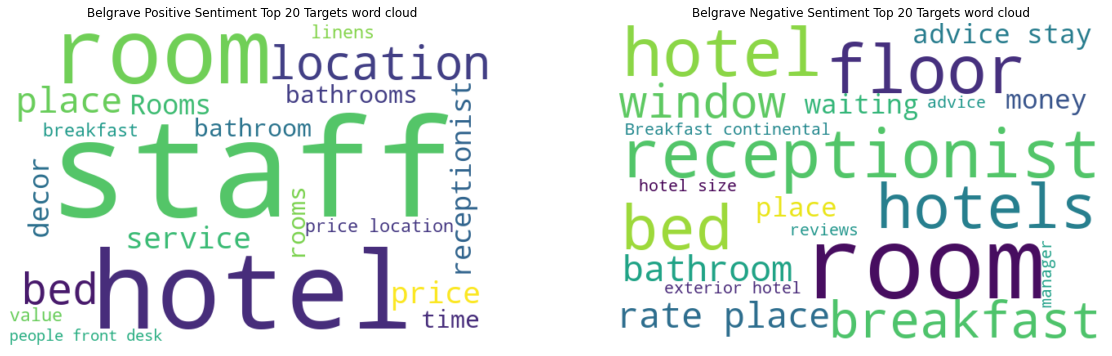

In [37]:
create_word_cloud_list([pd.DataFrame(pos_targets_belgrave)[0], pd.DataFrame(neg_targets_belgrave)[0]], 
                       "Sentiment Top 20 Targets word cloud", 
                       ['Belgrave Positive', 'Belgrave Negative'])

At a glance, we can see that the Belgrave hotel is positively reviewed for its price, staff, and service, while it is negatively reviewed for its receptionist, breakfast, and looks. It is reasonable to room as an entity in both positive and negative reviews as the subject of a hotel review is usually targeted towards its rooms.

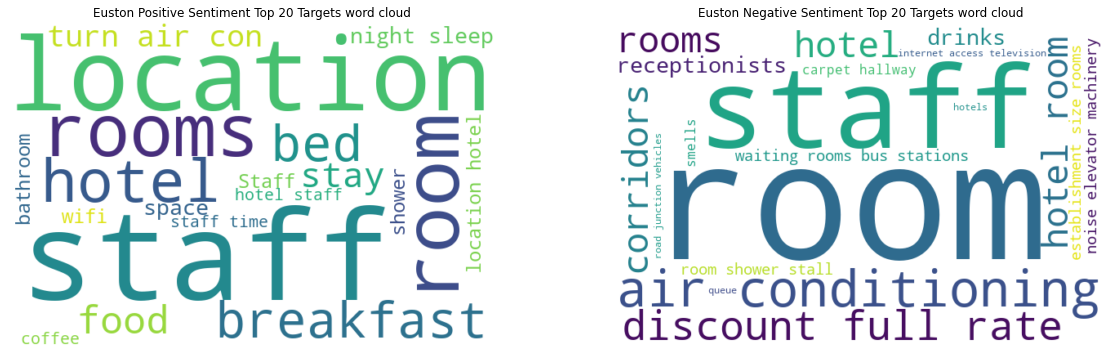

In [38]:
create_word_cloud_list([pd.DataFrame(pos_targets_euston)[0], pd.DataFrame(neg_targets_euston)[0]], 
                       "Sentiment Top 20 Targets word cloud", 
                       ['Euston Positive', 'Euston Negative'])

We can see that the Euston hotel is positively reviewed for its price, staff, and location, while it is negatively reviewed for its receptionist and air conditioning. Once again the room entity shows up in both positive and negative reviews.

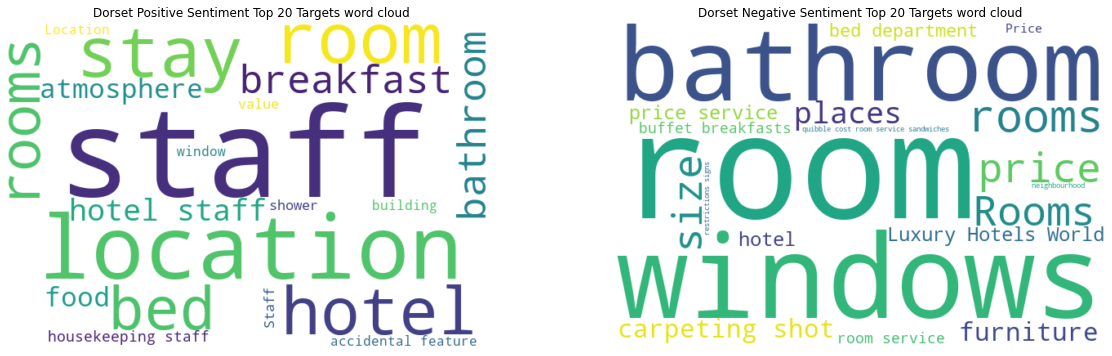

In [39]:
create_word_cloud_list([pd.DataFrame(pos_targets_dorset)[0], pd.DataFrame(neg_targets_dorset)[0]], 
                       "Sentiment Top 20 Targets word cloud", 
                       ['Dorset Positive', 'Dorset Negative'])

We can see that the Dorset hotel is positively reviewed for its location, staff, and breakfast, while it is negatively reviewed for its windows, bathroom, and price. It is likely that customers aren't feeling that they are getting their value out of the Dorset hotel based on the negatively sentiment around price, paid wifi, room service, and bed department. 

By examining the positive and negative entity sentiment list, we can quickly determine which aspect of the hotel need improvement and which aspects the hotel excels at.

## 6. Summary

This notebook shows you how to use the Watson NLP library and how easily you can run various entity, phrase, and target sentiment extraction models on input text. This notebook also demonstrated one possible application of Watson NLP.

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the (GitHub)[https://github.com/ibm-build-labs/Watson-NLP].

Developed by IBM Build Lab

Copyright - 2022 IBM Corporation